In [1]:
from i_o import Paths
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os, glob, h5py
import importlib, pathlib
from daio.h5 import lazyh5
from video import create_projection_image, showvid
import warpfield
from IPython.display import JSON

/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
pn_out = r"~/hpc-rw/lfm/results"
includes = ['']
excludes = []

recs = [os.path.basename(rec) for rec in sorted(glob.glob(os.path.expanduser(os.path.join(pn_out, '*'))), reverse=True) if os.path.exists(os.path.join(pn_out, rec, 'deconvolved.h5'))]
recs = [rec for rec in recs if all([s in rec for s in includes]) and not any([s in rec for s in excludes])]
print('\n'.join(recs))

20250701_1625_LB_ZF_v552_f7_40fps_2
20250701_1622_LB_ZF_v552_f7_40fps_1
20250701_1605_LB_ZF_v552_f6_40fps_1
20250701_1538_LB_ZF_v552_f5_40fps_1
20250701_1501_LB_ZF_v552_f3_40fps_2
20250514_1635_LF_ZF552_f4_1_comp_40fps
20250514_1515_LF_ZF552_f1_4_uncomp_40fps
20250513_1351_LB_redFB_1-1k_3d_with_movement


In [5]:
pn_psfs = r"~/hpc-rw/lfm/psfs"
pn_rec = r"~/hpc-r/lfm2025/recordings"
pn_bg = r"~/hpc-rw/lfm/bg"
url_home = r"/home/lubo12/"
pn_out = r"~/hpc-rw/lfm/results"

dataset_name = "20250701_1538_LB_ZF_v552_f5_40fps_1"
psf_name = "20250701_1216_PSF_LB_noap_1"
bg_name = "20250701_1651_LB_bg_40fps.npy"

paths = Paths(dataset_name=dataset_name,
              psf_name = psf_name,
              bg_name=bg_name,
              pn_bg= pn_bg,
              pn_rec = pn_rec,
              pn_psfs=pn_psfs,
              pn_out=pn_out,
              url_home=url_home,
              )

In [6]:
#generate default registration recipe
recipe = warpfield.Recipe.from_yaml('default.yml')

### Generate reference volume from recording

In [27]:
import register, i_o
importlib.reload(register)
from register import reference_volume
importlib.reload(i_o)
from i_o import VolumeReader

In [28]:
#inspect theindexes to use for generating the refenrence - should be very little movement
ref_idx = [0,100,1]
ref_vol_unreg, video_fn = reference_volume(paths,
                                             ref_idx,
                                              vmax=100,
                                              vmin=0,
                                              absolute_limits=False)

showvid(video_fn)

Averaging:   0%|          | 0/100 [00:00<?, ?it/s]

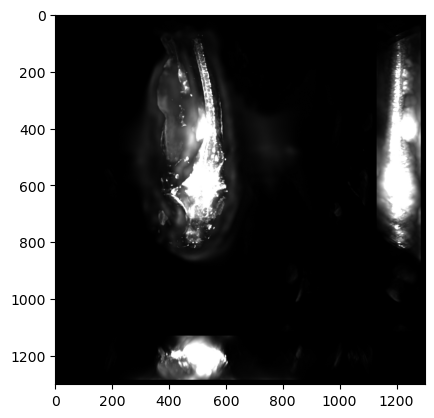

In [33]:
plt.imshow(create_projection_image(ref_vol_unreg, vmax=5, vmin=0, absolute_limits=False), cmap="gray")

In [39]:
#refine reference volume by registering every volume to the average and then averaging again
def register_reference(vol, ref_vol, register_recipe):
    return warpfield.register_volume(vol, ref_vol, register_recipe)


ref_vol, video_fn = reference_volume(paths,
                                      ref_idx,
                                     preprocess = register_reference,
                                      vmax=100,
                                      vmin=0,
                                      absolute_limits=False,
                                    register_recipe=recipe,
                                    ref_vol=ref_vol_unreg,
                                      )

showvid(video_fn)

Averaging:   0%|          | 0/100 [00:00<?, ?it/s]

AttributeError: module 'warpfield' has no attribute 'register_volume'

In [ ]:
#adjust registration params

### Test mini registration

In [50]:
import warpfield

# 1. Load data (note: the two volumes are expected to be of the same array shape and resolution)
vol_ref, _ = warpfield.register.load_data("reference_volume.npy")
vol_mov, _ = warpfield.register.load_data("moving_volume.npy")

# 2. Choose registration recipe (here: loaded from a YAML file. See below for alternatives)
recipe = warpfield.Recipe.from_yaml('default.yml')

# 3. Register moving volume
vol_mov_reg, warp_map, _ = warpfield.register_volume(vol_ref, vol_mov, recipe)

# 4. Optional: apply the transformation to another volume (same shape and resolution)
vol_another_reg = warp_map.apply(vol_another)

# 5. Optional: apply inverse transformation to the reference volume
vol_ref_reg = warp_map.invert().apply(vol_ref)

# 6. Optional: apply the warp transformation to a set of coordiantes (3-by-n array, in units of volume voxels)
points = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]])
points_pushed = warp_map.push_coordinates(points)
points_pulled = warp_map.invert().push_coordinates(points) # inverse transformation

AttributeError: module 'warpfield.register' has no attribute 'load_data'

In [43]:
dir(warpfield)

['Recipe',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'load_data',
 'ndimage',
 'register',
 'register_volumes',
 'utils',
 'warp']

In [48]:
from inspect import getmembers, isfunction

from warpfield import register, register_volumes, load_data, ndimage, warp, utils
print(getmembers(register, isfunction))
print(getmembers(register_volumes, isfunction))
print(getmembers(load_data, isfunction))
print(getmembers(warp, isfunction))
print(getmembers(utils, isfunction))

[('accumarray', <function accumarray at 0x14e5c323ff60>), ('create_rgb_video', <function create_rgb_video at 0x14e5c334d940>), ('dogfilter', <function dogfilter at 0x14e5c334de40>), ('gausskernel_sheared', <function gausskernel_sheared at 0x14e5c334e0c0>), ('infill_nans', <function infill_nans at 0x14e597c58040>), ('mips_callback', <function mips_callback at 0x14e5c334da80>), ('ndwindow', <function ndwindow at 0x14e5c323f100>), ('periodic_smooth_decomposition_nd_rfft', <function periodic_smooth_decomposition_nd_rfft at 0x14e5c334dee0>), ('register_volumes', <function register_volumes at 0x14e5c5cc4b80>), ('sliding_block', <function sliding_block at 0x14e597c580e0>), ('soften_edges', <function soften_edges at 0x14e597c582c0>), ('upsampled_dft_rfftn', <function upsampled_dft_rfftn at 0x14e597c58180>), ('warp_volume', <function warp_volume at 0x14e5c334d6c0>)]
[]
[]
[('warp_volume', <function warp_volume at 0x14e5c334d6c0>)]
[('create_rgb_video', <function create_rgb_video at 0x14e5c334d9